In [2]:
import tensorflow as tf
import numpy as np
import random
import time  
import matplotlib.pyplot as plt
from PIL import Image
import os
import sys
import scipy.io as scp
import sklearn as skl
import  urllib.request as urlreq
import random
from IPython.display import display, Image

from datetime import datetime
%matplotlib inline
print ("Tensor flow version is -- ", tf.__version__)

tf.test.is_gpu_available()

Tensor flow version is --  1.0.0


True

In [3]:
url         =   "http://ufldl.stanford.edu/housenumbers/" 
prefix      =   "mat/" 

last_percent_reported = None

def progress_hook(count, blockSize, totalSize): 
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 10 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

    last_percent_reported = percent
    
    
def maybe_download(filename, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(prefix+filename):
        print('Starting download ', filename) 
        filename, _ = urlreq.urlretrieve(url + filename, prefix+filename, reporthook= progress_hook)
        print('\nDownload Complete! and saved at ', filename)
        statinfo = os.stat(filename) 
    else:
        filename = prefix+filename
        print('Not downloading, file already present at ', filename) 
    return filename

def load_mat( ):     
    test_matfile  = maybe_download('test_32x32.mat')
    train_matfile = maybe_download('train_32x32.mat')
    valid_matfile = maybe_download('extra_32x32.mat')
    
    print ("Loading .mat files to memory ....")
    testdata_fun  = scp.loadmat(test_matfile)
    print ("....")
    traindata_fun  = scp.loadmat(train_matfile)
    print ("....")
    extradata_fun  = scp.loadmat(valid_matfile)
    print ("... Loading done.")
 
    return testdata_fun , traindata_fun , extradata_fun  



In [4]:
testdata, traindata, extradata  = load_mat()

Not downloading, file already present at  mat/test_32x32.mat
Not downloading, file already present at  mat/train_32x32.mat
Not downloading, file already present at  mat/extra_32x32.mat
Loading .mat files to memory ....
....
....
... Loading done.


In [6]:
def normalize(image_array):
    size=image_array.shape[0]
    mean    =  np.mean(image_array, axis=(1,2), dtype=float)
    std_dev =  np.std (image_array, axis=(1,2), dtype=float, ddof=1)
    
    
    std_dev[std_dev < 1.0e-3] = 1. 
    ret_image_array = np.zeros(image_array.shape,dtype=float) 
    
    for i in np.arange(size):
        ret_image_array[i,:,:] = (image_array[i,:,:] - mean[i])/std_dev[i]
    
    del image_array
    return ret_image_array
 
    
    
x_train_rgb  = traindata.get('X')
train_labels = traindata.get('y')
train_labels = train_labels.reshape( train_labels.shape[:1] )
train_labels[train_labels == 10] = 0
train_labels = train_labels.astype(np.int32)
x_train_rgb  = np.transpose(x_train_rgb, (3, 0, 1, 2)) 
x_train_labels = train_labels
train_data   = np.zeros((len(train_labels),32,32) )
train_data   = np.dot(x_train_rgb , [[0.2989],[0.5870],[0.1140]]) 
train_data   = normalize(train_data)
train_data   = train_data.astype(np.float32)
print( "train_data prepared") 
del  x_train_rgb


x_test_rgb  = testdata.get('X')
test_labels = testdata.get('y')
test_labels = test_labels.reshape( test_labels.shape[:1] )
test_labels[test_labels == 10] = 0
test_labels = test_labels.astype(np.int32)
x_test_rgb  = np.transpose(x_test_rgb, (3, 0, 1, 2)) 
x_test_labels  = test_labels  
test_data   = np.zeros((len(test_labels),32,32) )
test_data   = np.dot(x_test_rgb , [[0.2989],[0.5870],[0.1140]]) 
test_data   = normalize(test_data) 
test_data   = test_data.astype(np.float32) 
print( "test_data prepared") 
del  x_test_rgb


x_extra_rgb  = extradata.get('X')
extra_labels = extradata.get('y')
extra_labels = extra_labels.reshape( extra_labels.shape[:1] )
extra_labels[extra_labels == 10] = 0
extra_labels = extra_labels.astype(np.int32)
x_extra_rgb  = np.transpose(x_extra_rgb, (3, 0, 1, 2)) 
x_extra_labels  = extra_labels
extra_data   = np.zeros((len(extra_labels),32,32) )
extra_data   = np.dot(x_extra_rgb , [[0.2989],[0.5870],[0.1140]]) 
#extra_data   = extra_data.reshape(extra_data.shape[:3])
extra_data   = normalize(extra_data)
extra_data   = extra_data.astype(np.float32)
print( "extra_data prepared") 
del  x_extra_rgb



train_data prepared
test_data prepared
extra_data prepared


In [8]:
#prepare training and validation dataset
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0]) 
    return dataset[permutation,:,:], labels[permutation] 

validation_size = train_data.shape[0]+extra_data.shape[0]-600000 


all_data = np.concatenate((train_data,extra_data), axis=0)
all_labels = np.concatenate((train_labels,extra_labels), axis=0)
del train_data, extra_data, train_labels, extra_labels

print ("Training plus validation size", all_data.shape, all_labels.shape)
print ("Size of validation dataset -->", validation_size)
print ("Size of test dataset -->", test_data.shape[0])

all_data, all_labels = randomize(all_data, all_labels)


train_data   = all_data[:-validation_size,:,:]
train_labels = all_labels[:-validation_size] 

valid_data   = all_data[-validation_size:,:,:]
valid_labels = all_labels[-validation_size:] 
del all_data, all_labels
 
print ('Train data:', train_data.shape,', Train labels:', train_labels.shape)
print ('Valid data:', valid_data.shape,', Valid labels:', valid_labels.shape)
print ('Test data:', test_data.shape,', Test labels:', test_labels.shape)


print( tf.Print(test_data[1,:,:,:],[test_data[1,:,:,:]]),"\n", tf.Print(train_data[1,:,:,:],[train_data[1,:,:,:]]),"\n", tf.Print(valid_data[1,:,:,:],[valid_data[1,:,:,:]] ))

print( tf.Print(test_labels,[test_labels]),"\n", tf.Print(train_labels ,[train_labels ]),"\n", tf.Print(valid_labels ,[valid_labels ] ))


Training plus validation size (604388, 32, 32, 1) (604388,)
Size of validation dataset --> 4388
Size of test dataset --> 26032
Train data: (600000, 32, 32, 1) , Train labels: (600000,)
Valid data: (4388, 32, 32, 1) , Valid labels: (4388,)
Test data: (26032, 32, 32, 1) , Test labels: (26032,)
Tensor("Print:0", shape=(32, 32, 1), dtype=float32) 
 Tensor("Print_1:0", shape=(32, 32, 1), dtype=float32) 
 Tensor("Print_2:0", shape=(32, 32, 1), dtype=float32)
Tensor("Print_3:0", shape=(26032,), dtype=int32) 
 Tensor("Print_4:0", shape=(600000,), dtype=int32) 
 Tensor("Print_5:0", shape=(4388,), dtype=int32)


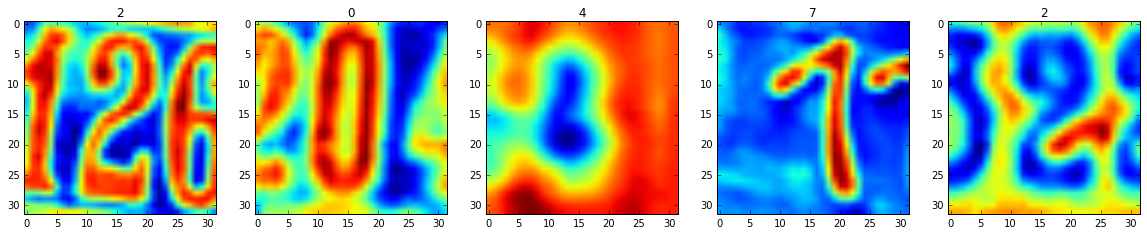

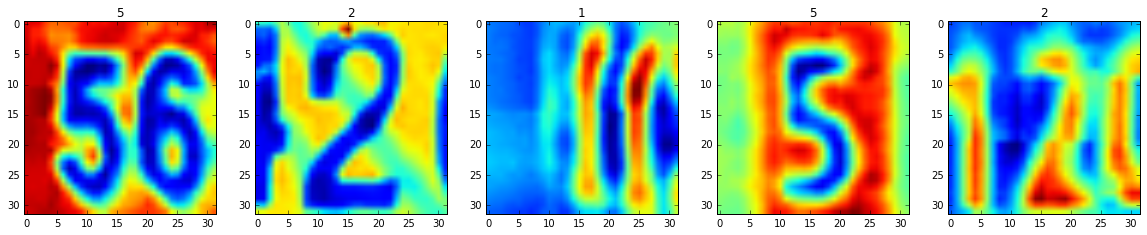

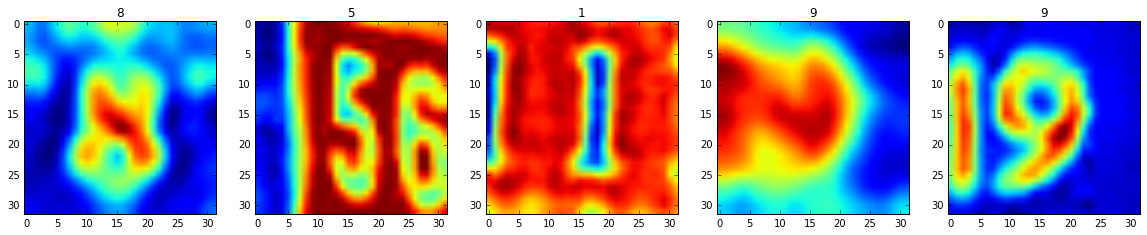

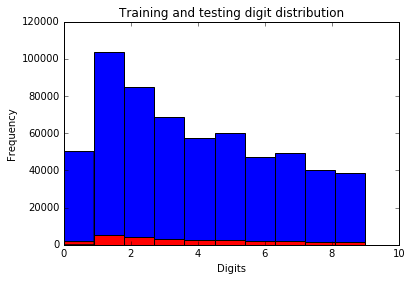

In [9]:
def showgreyscale(data, label): 
    fig=plt.figure(1,figsize=(20, 10))
    size=5
    l=np.random.randint(0,len(label),size)
#   print( l)
    for i in range(1,6,1):
        plt.subplot(1,5,i)
#       print (label[l[i-1] ], data[ l[i-1]].shape)
        plt.title(label[l[i-1] ], loc='center')
        plt.imshow(data[ l[i-1] ,:,:])
    plt.show()
    plt.close(fig)
        
showgreyscale(train_data[:,:,:,0], train_labels)
showgreyscale(valid_data[:,:,:,0], valid_labels)
showgreyscale(test_data[:,:,:,0], test_labels)


plt.hist(train_labels, label='training labels' )
plt.hist(valid_labels, label='validation set training labels' )
plt.hist(test_labels, label='testing labels')
#plt.hist(valid_labels, label='validation labels')
plt.title("Training and testing digit distribution")
plt.xlabel("Digits")
plt.ylabel("Frequency")

fig = plt.gcf()

In [72]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))
def new_biases(length):
    return tf.Variable(tf.constant(1.0, shape=[length]))

#  images are 32 pixels in each dimension.
image_size = 32 
num_channels = 1 
num_classes = 10  
batch_size= 64
  

#convolution layer1
filter_size = 5 #5x5 pixels
num_filters1 = 16 #and 16 filters

#convolution layer2
num_filters2 = 32

#convolution layer3
num_filters3 = 64

#convolution layer4
num_filters4 = 128

#convolution layer5
num_filters5 = 256

fc_size1 = 32 

graph = tf.Graph()

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))    
    tf_train_labels  = tf.placeholder(tf.int64, shape=(batch_size))
    tf_valid_dataset = tf.constant(valid_data)
    tf_test_dataset  = tf.constant(test_data)
    
    weights1 = new_weights(shape=[filter_size, filter_size, num_channels, num_filters1]) 
    biases1  = new_biases (length=num_filters1)  
    

    tf.summary.histogram('weights1',weights1)
    
    weights2 = new_weights(shape=[filter_size, filter_size, num_filters1, num_filters2]) 
    biases2  = new_biases (length=num_filters2)  
    
    
    weights3 = new_weights(shape=[filter_size, filter_size, num_filters2, num_filters3]) 
    biases3  = new_biases (length=num_filters3)  
     
    
    weights_fc1 = new_weights(shape=[ 1*1*num_filters3, fc_size1]) 
    biases_fc1 = new_biases (length=fc_size1)  
    
    weights_fc2 = new_weights(shape=[ fc_size1, num_classes]) 
    biases_fc2  = new_biases (length=num_classes)  
    
    
    
    with tf.name_scope('conv_model'):
        def conv_model(data, keep_prob=1):

            print ( "Input Data shape ", tf.Print(data,[data]) )   


            with tf.name_scope('layer1'):
        # LAYER 1  converts 32 x 32 x 1  to  16 x 16 x 16       
                layer   = tf.nn.conv2d(input=data,  filter=weights1, strides=[1, 1, 1, 1],  padding='VALID') 
                layer0  = tf.nn.relu(layer+biases1)
                lrn     = tf.nn.lrn(layer0) 
                maxpool = tf.nn.max_pool(value=lrn, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                print ( "Conv. Layer 1 shape ", maxpool.shape)   



        # LAYER 2 converts 16 x 16 x 16  to 8 x 8 x 32  
            with tf.name_scope('layer2'):
                layer   = tf.nn.conv2d(input=maxpool,  filter=weights2, strides=[1, 1, 1, 1],  padding='VALID') 
                layer0  = tf.nn.relu(layer+biases2)
                lrn     = tf.nn.local_response_normalization(layer0) 
                maxpool = tf.nn.max_pool(value=lrn, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                print ( "Conv. Layer 2 shape ", maxpool.shape)   


        # LAYER 3 converts 8 x 8 x 32   to 4 x 4 x 64                
            with tf.name_scope('layer3'):     
                layer   = tf.nn.conv2d(input=maxpool,  filter=weights3, strides=[1, 1, 1, 1],  padding='VALID') 
                layer0  = tf.nn.relu(layer+biases3) 
                lrn     = tf.nn.local_response_normalization(layer0) 
                dropout = tf.nn.dropout(lrn, keep_prob)    
                print ( "Conv. Layer 3 shape ", dropout.shape)     



        # Flatten the previous layer   
                dropout_shape  =   dropout.get_shape().as_list()
                num_features   =   dropout_shape[1] * dropout_shape[2] * dropout_shape[3]
                layer_flat     =   tf.reshape(dropout, [dropout_shape[0], num_features]) 
                print ( "After Flattening Layer 3 shape ", layer_flat.shape," and num of features ", num_features)


        # LAYER 4  Fully connected     
            with tf.name_scope('Final_FC_Layer1'):     
                layer_fc1    = tf.nn.relu(tf.matmul(layer_flat, weights_fc1) + biases_fc1 )
                print ( "Fully connected Layer 1 shape ", layer_fc1.shape)       


        # LAYER 5  Fully connected   
            with tf.name_scope('Final_FC_Layer2'):   
                layer_fc2    =  tf.matmul(layer_fc1, weights_fc2) + biases_fc2
                print ( "Fully connected Layer 2 shape ", layer_fc2.shape,"\n\n" ) 

            return layer_fc2
    
    logits = conv_model(tf_train_dataset, 0.9 )
    with tf.name_scope ('loss'):
        loss   = tf.reduce_mean(    tf.nn.sparse_softmax_cross_entropy_with_logits( labels= tf_train_labels , logits=logits )  )  
        tf.summary.scalar('loss',loss)
    # Defining learning rate and optimizer
    global_step = tf.Variable(0)
    learning_rate = 0.1
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #learning_rate = tf.train.exponential_decay(0.1, global_step, 40000, 0.9)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #optimizer = tf.train.AdadeltaOptimizer (learning_rate).minimize(loss, global_step=global_step)  
    # Predictions for the training, validation, and test data.
    
    with tf.name_scope ('training_accuracy'):   
        train_prediction = tf.nn.softmax(conv_model(tf_train_dataset, 1.0)) 
        temp1 = tf.transpose (tf.argmax(train_prediction,axis=1) ) 
        temp2 = tf.equal( temp1 , tf_train_labels) 
        temp3 = tf.reduce_sum ( tf.to_float(temp2 ) )
        train_acc_dig  = 100.0*temp3/tf.to_float( (tf_train_labels.shape[0]  ) )
        tf.summary.scalar('training_accuracy_dig',train_acc_dig)
    
    
    with tf.name_scope ('valid_accuracy'):
        valid_prediction = tf.nn.softmax(conv_model(tf_valid_dataset, 1.0))
        temp1 = tf.transpose (tf.argmax(valid_prediction,axis=1) ) 
        temp2 = tf.equal( temp1 , valid_labels) 
        temp3 = tf.reduce_sum ( tf.to_float(temp2 ) )
        valid_acc_dig  = 100.0*temp3/tf.to_float( (valid_labels.shape[0]  ) )
        tf.summary.scalar('valid_accuracy_dig',valid_acc_dig)
    
    test_prediction  = tf.nn.softmax(conv_model(tf_test_dataset, 1.0)) 
    temp1 = tf.transpose (tf.argmax(test_prediction,axis=1) ) 
    temp2 = tf.equal( temp1 , test_labels) 
    temp3 = tf.reduce_sum ( tf.to_float(temp2 ) )
    test_acc_dig  = 100.0*temp3/tf.to_float( (test_labels.shape[0]  ) )
    
    # Merge all summaries into a single operator
    merged  = tf.summary.merge_all()
    
    # Save model
    saver = tf.train.Saver()

Input Data shape  Tensor("Print:0", shape=(64, 32, 32, 1), dtype=float32)
Conv. Layer 1 shape  (64, 14, 14, 16)
Conv. Layer 2 shape  (64, 5, 5, 32)
Conv. Layer 3 shape  (64, 1, 1, 64)
After Flattening Layer 3 shape  (64, 64)  and num of features  64
Fully connected Layer 1 shape  (64, 32)
Fully connected Layer 2 shape  (64, 10) 


Input Data shape  Tensor("training_accuracy/Print:0", shape=(64, 32, 32, 1), dtype=float32)
Conv. Layer 1 shape  (64, 14, 14, 16)
Conv. Layer 2 shape  (64, 5, 5, 32)
Conv. Layer 3 shape  (64, 1, 1, 64)
After Flattening Layer 3 shape  (64, 64)  and num of features  64
Fully connected Layer 1 shape  (64, 32)
Fully connected Layer 2 shape  (64, 10) 


Input Data shape  Tensor("valid_accuracy/Print:0", shape=(4388, 32, 32, 1), dtype=float32)
Conv. Layer 1 shape  (4388, 14, 14, 16)
Conv. Layer 2 shape  (4388, 5, 5, 32)
Conv. Layer 3 shape  (4388, 1, 1, 64)
After Flattening Layer 3 shape  (4388, 64)  and num of features  64
Fully connected Layer 1 shape  (4388, 32)

In [73]:
 
# starting session and run computation
num_steps = 50001
print('Training start time: ', str(datetime.now()))
with tf.Session(graph=graph,config=tf.ConfigProto(log_device_placement=True)) as session:
    file_writer = tf.summary.FileWriter('./board_s_adagrad', session.graph)  
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_data[offset:(offset + batch_size), :, :,:]
        batch_labels = train_labels[offset:(offset + batch_size)]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, tr_acc_dig = session.run([optimizer, loss, train_acc_dig], feed_dict=feed_dict)
        if (step % 500 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch Training accuracy: %.2f%%' % (tr_acc_dig))
            print('Validation accuracy: %.2f%%\n\n' % (valid_acc_dig.eval()))
            _, merged_sum = session.run([optimizer,merged], feed_dict=feed_dict)
            file_writer.add_summary ( merged_sum, step )
    print('Test accuracy: %.2f%%' % (test_acc_dig.eval()) )
    save_path = saver.save(session, "SVHN_single_ada.ckpt")
    print('Training end time: ', str(datetime.now()))
    print("Model saved in file: %s" % save_path)
    

Training start time:  2017-03-20 09:42:33.360582
Initialized
Minibatch loss at step 0: 2.385974
Minibatch Training accuracy: 9.38%
Validation accuracy: 14.86%


Minibatch loss at step 500: 1.467960
Minibatch Training accuracy: 60.94%
Validation accuracy: 44.85%


Minibatch loss at step 1000: 0.494230
Minibatch Training accuracy: 82.81%
Validation accuracy: 87.85%


Minibatch loss at step 1500: 0.312417
Minibatch Training accuracy: 90.62%
Validation accuracy: 90.59%


Minibatch loss at step 2000: 0.237476
Minibatch Training accuracy: 93.75%
Validation accuracy: 91.93%


Minibatch loss at step 2500: 0.351566
Minibatch Training accuracy: 92.19%
Validation accuracy: 92.71%


Minibatch loss at step 3000: 0.433552
Minibatch Training accuracy: 89.06%
Validation accuracy: 93.23%


Minibatch loss at step 3500: 0.244327
Minibatch Training accuracy: 93.75%
Validation accuracy: 93.14%


Minibatch loss at step 4000: 0.442140
Minibatch Training accuracy: 84.38%
Validation accuracy: 93.92%


Minibatc